# Causal Influence Decomposition of the Human Brain Using Multi-site In-silico Perturbation Analysis


In [103]:
%load_ext autoreload
%autoreload 2

##  we're using the following packages (see requirements.txt for more):

#   msapy == 1.1.0
#   netneurotools 0.2.3
#   numpy == 1.20.3
#   numba == 0.56.4
#   pandas == 1.3.5 ## make sure it's not 1.5 otherwise somehow the causal influence matrices shift and we still don't know why because the tests all pass with both versions!
#   bctpy == 0.6.0
#   networkx == 3.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import numpy as np
from msapy import msa, plottings as pl
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import utils as ut
import pandas as pd
from netneurotools.metrics import communicability_wei, communicability_bin, distance_wei_floyd
from scipy.stats import pearsonr
import warnings
from sklearn.preprocessing import StandardScaler
import scipy

In [105]:
SEED = 2023
pl.set_style(font_size=8)
CM = 1/2.54

DEEP_BLUE = '#006685'
BLUE = '#3FA5C4'
WHITE = '#FFFFFF'
HALF_BLACK = '#232324'
ORANGE = '#E84653'
RED= '#BF003F'

PURPLE = '#A6587C'
PURPLER = '#591154'
PURPLEST = '#260126'
NIGHT_BLUE = '#394D73'
YELLOW = '#E6B213'


from_white = [DEEP_BLUE, BLUE, WHITE, ORANGE, RED]
white_to_reds = [WHITE, ORANGE, RED]
white_to_blues = [WHITE, BLUE, DEEP_BLUE]

black_to_reds = [HALF_BLACK, ORANGE, RED]
black_to_blues = [HALF_BLACK, BLUE, DEEP_BLUE]

from_black = [DEEP_BLUE,BLUE,HALF_BLACK,ORANGE,RED]



diverge_from_white = sns.blend_palette(from_white,as_cmap=True)
diverge_from_black = sns.blend_palette(from_black,as_cmap=True)

white_red_mono = sns.blend_palette(white_to_reds,as_cmap=True)
white_blue_mono = sns.blend_palette(white_to_blues,as_cmap=True)

black_red_mono = sns.blend_palette(black_to_reds,as_cmap=True)
black_blue_mono = sns.blend_palette(black_to_blues,as_cmap=True)

purple_red = sns.blend_palette([PURPLEST, PURPLE, RED])

sagittal=(0, 180)
axial=(90, 180)
coronal=(0, 90)
bottom=(-90,0)

In [106]:
rng = np.random.default_rng(seed=SEED)
chain = nx.to_numpy_array(nx.generators.path_graph(6,nx.DiGraph())).T


closedchain = chain.copy()
closedchain[0,5]=1
closedchain = ut.spectral_normalization(0.9,closedchain)

chain *= 0.9

symmetricchain = nx.to_numpy_array(nx.generators.path_graph(6))
symmetricchain = ut.spectral_normalization(0.9,symmetricchain)

timesteps = 100
example_input = ut.event_maker(6,timesteps)


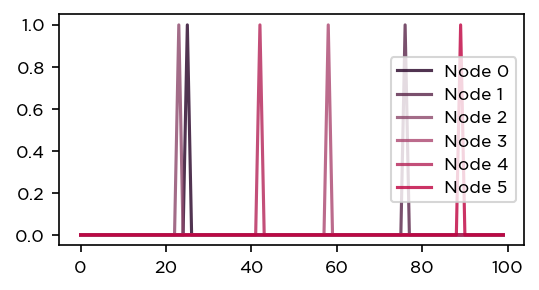

In [107]:
plt.figure(figsize=(4,2),dpi=150)
with sns.color_palette(purple_red,n_colors=example_input.shape[0]):
    plt.plot(example_input.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5']);

In [108]:
NOISE_STRENGTH = 0.05
DELTA = 0.01
TAU = 0.02
G =0.74
DURATION = 1
model_params = {'dt':DELTA,'timeconstant':TAU,'coupling':G,'duration':DURATION}

In [109]:
warnings.filterwarnings("ignore")

simple_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=chain,
                                                              input_matrix=example_input,
                                                                 **model_params)
closed_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=closedchain,
                                                              input_matrix=example_input,
                                                                 **model_params)
symmetric_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=symmetricchain,
                                                                 input_matrix=example_input,
                                                                 **model_params)

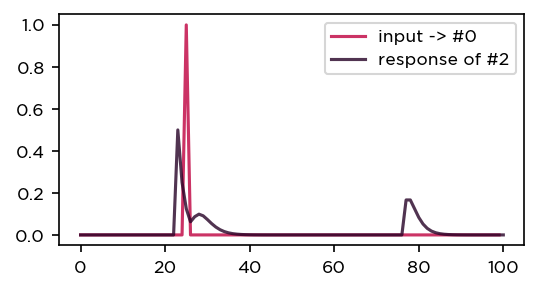

In [110]:
plt.figure(figsize=(4,2),dpi=150)

plt.plot(example_input[0],alpha=0.8,color=RED)
plt.plot(simple_chain_dynamics[2],alpha=0.8,color=PURPLEST)

plt.legend(['input -> #0','response of #2']);


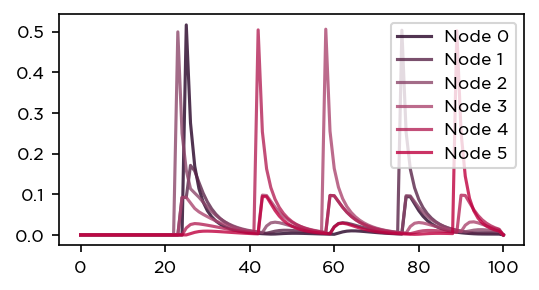

In [111]:
plt.figure(figsize=(4,2),dpi=150)
with sns.color_palette(purple_red,n_colors=example_input.shape[0]):
    plt.plot(symmetric_chain_dynamics.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5'])

In [112]:
cchain= communicability_bin(chain)
cchain[np.diag_indices_from(cchain)] = 0

ccchain= communicability_wei(closedchain)
ccchain[np.diag_indices_from(cchain)] = 0

csychain= communicability_wei(symmetricchain)
csychain[np.diag_indices_from(cchain)] = 0


In [113]:
lesion_params = {'adjacency_matrix': chain, 'input': example_input, 'model_kwargs': model_params}
ci_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['adjacency_matrix'] = closedchain
ci_closed_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['adjacency_matrix'] = symmetricchain
ci_symmetric_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)



0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 13591.67it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 14111.84it/s]
2it [00:00, 16.32it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 13991.22it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 11418.90it/s]
4it [00:00, 15.82it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 4010.93it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 10710.00it/s]
6it [00:00, 14.78it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 10415.78it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 10803.10it/s]
2it [00:00, 14.55it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 10487.40it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 12182.78it/s]
4it [00:00, 13.95it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 15604.90it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 14077.80it/s]
6it [00:00, 14.67it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 14257.25it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 14804.51it/s]
2it [00:00, 14.90it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 14184.92it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 14670.21it/s]
4it [00:00, 15.76it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 15570.50it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 14536.74it/s]
6it [00:00, 16.06it/s]


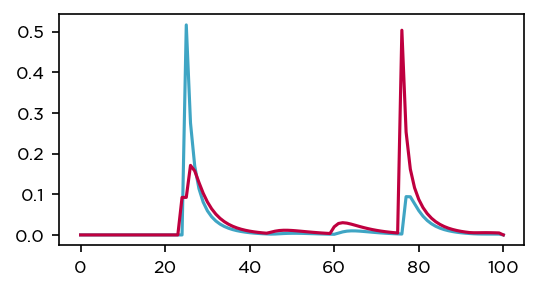

In [114]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(symmetric_chain_dynamics[0],color=BLUE)
plt.plot(symmetric_chain_dynamics[1],color=RED)

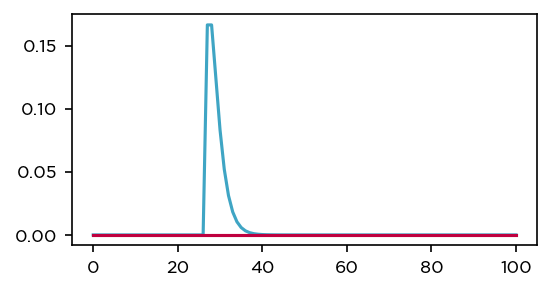

In [115]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(ci_chain[0][1],color=BLUE) #influence of 0 on 1
plt.plot(ci_chain[1][0],color=RED) #influence of 1 on 0

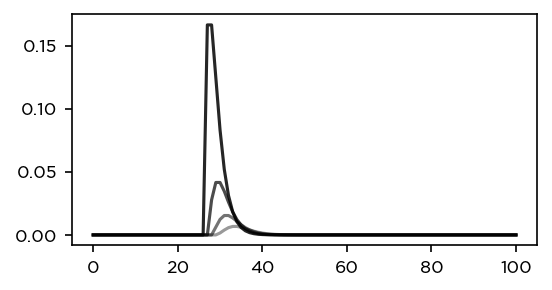

In [116]:
plt.figure(figsize=(4,2),dpi=150)
for i in range(5):
    plt.plot(ci_chain[0][i],color='k',alpha=1-i*0.15) #influence of 0 over the rest


In [117]:
ci_chain = ci_chain.groupby(level=0).var().fillna(0)
ci_closed_chain = ci_closed_chain.groupby(level=0).var().fillna(0)
ci_symmetric_chain = ci_symmetric_chain.groupby(level=0).var().fillna(0)

In [118]:
chain_mask = np.where(cchain!=0,1,0)
closedchain_mask = np.where(ccchain!=0,1,0)
symmetricchain_mask = np.where(csychain!=0,1,0)

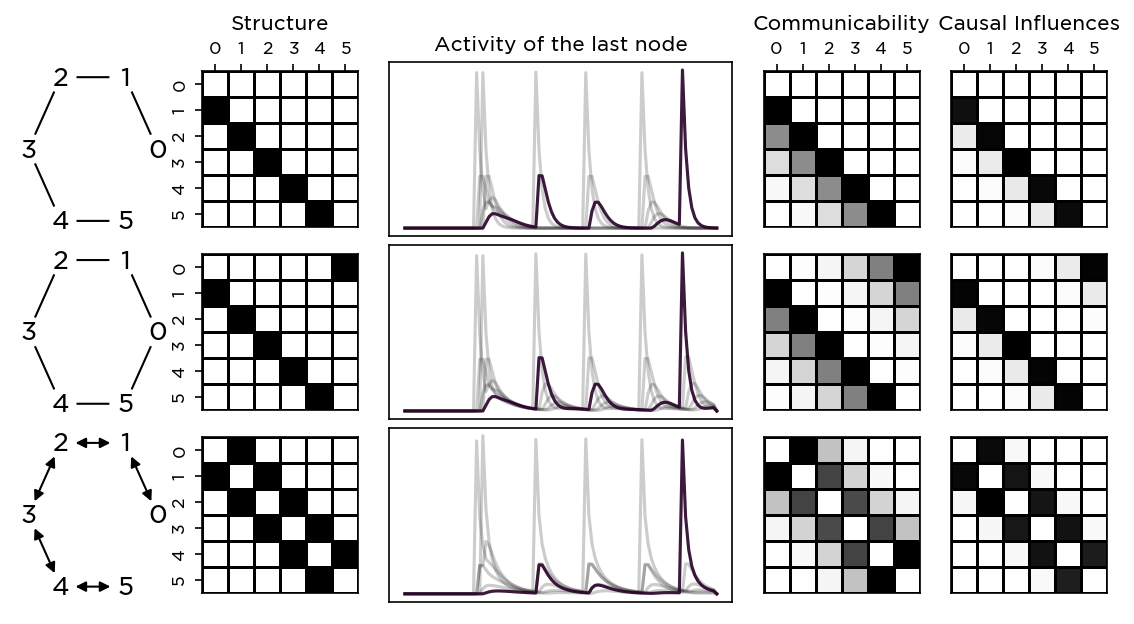

In [119]:
fig,axes = plt.subplot_mosaic([['A','X','B', 'B','CX','CIX'],
                               ['C','Y','D', 'D','CY','CIY'],
                               ['E','Z','F', 'F','CZ','CIZ']],figsize=(7.3,4),dpi=150)

#===================================== STRUCTURE
sns.heatmap(chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['X'],linewidths=0.5, linecolor='k')

sns.heatmap(closedchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Y'],linewidths=0.5, linecolor='k')

sns.heatmap(symmetricchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Z'],linewidths=0.5, linecolor='k')
#===================================== COMMUNICABILITY
sns.heatmap(cchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CX'],linewidths=0.5, linecolor='k')

sns.heatmap(ccchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CY'],linewidths=0.5, linecolor='k')

sns.heatmap(csychain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CZ'],linewidths=0.5, linecolor='k')
#===================================== CAUSAL INFLUENCE
sns.heatmap(ci_chain*chain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIX'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_closed_chain*closedchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIY'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_symmetric_chain*symmetricchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIZ'],linewidths=0.5, linecolor='k')


node_colors=[WHITE,WHITE,WHITE,WHITE,WHITE,WHITE]
nx.draw_circular(nx.from_numpy_array(chain),ax=axes['A'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(closedchain),ax=axes['C'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(symmetricchain),ax=axes['E'],
                 arrows=True,node_size=200,node_color=node_colors,arrowstyle='<|-|>',with_labels=True)
for ax in ['B','D','F']:

    axes[ax].yaxis.set_visible(False)

for ax in ['B','C','D','Y','Z']:
    axes[ax].xaxis.set_visible(False)
for i in range(len(chain)):
    if i < len(chain)-1:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

for i in range(len(chain)):
    if i < len(chain)-1:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

for i in range(len(chain)):
        if i < len(chain)-1:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c='k',alpha=0.2)
        else:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

axes['B'].title.set_text('Activity of the last node')
axes['X'].title.set_text('Structure')
axes['CX'].title.set_text('Communicability')
axes['CIX'].title.set_text('Causal Influences')

axes['B'].yaxis.tick_right()

for ax in ['X','CX','CIX']:
    axes[ax].xaxis.tick_top()
for ax in ['CY','CZ','CIY','CIZ','F']:
    axes[ax].xaxis.set_visible(False)

for ax in ['CX','CY','CZ','CIX','CIY','CIZ']:
    axes[ax].yaxis.set_visible(False)

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)
fig.tight_layout(pad=0.1)

#plt.savefig(f"chain_propagation.pdf",dpi=600,bbox_inches='tight')

In [120]:
consensus_mat = scipy.io.loadmat('Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
connectivity = ut.spectral_normalization(1,consensus_mat['LauConsensus']['Matrices'][2][0])
coordinates = consensus_mat['LauConsensus']['Matrices'][2][3]
labels = consensus_mat['LauConsensus']['Matrices'][2][4][:,0]

In [121]:
ut.check_symmetric(connectivity)

True

In [122]:
N_NODES = len(connectivity)
communication_mask = np.where(communicability_wei(connectivity)!=0,1,0)

In [123]:
rng = np.random.default_rng(seed=SEED)
input_noise = rng.normal(0, NOISE_STRENGTH, (N_NODES, int(DURATION/DELTA)+1))

simple_human_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                                              input_matrix=input_noise,
                                                              **model_params)

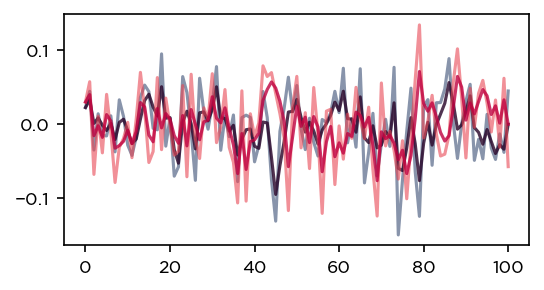

In [124]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(input_noise[-1],alpha=0.6,color=NIGHT_BLUE)
plt.plot(simple_human_dynamics[-1],alpha=0.8,color=PURPLEST)
plt.plot(input_noise[0],alpha=0.6,color=ORANGE)
plt.plot(simple_human_dynamics[0],alpha=0.8,color=RED);
#plt.savefig(f"example_activity.pdf",dpi=600,bbox_inches='tight')

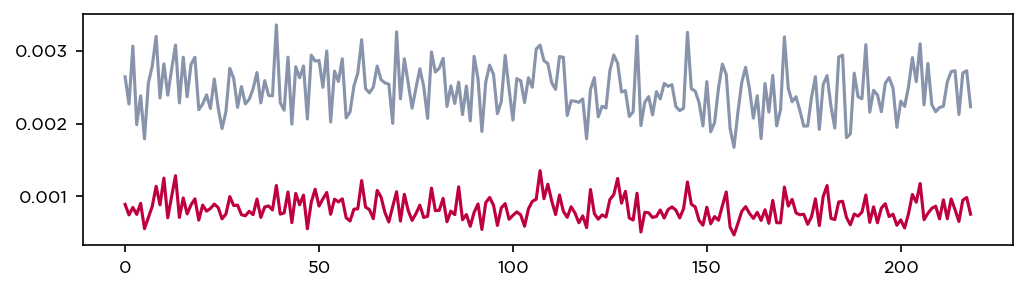

In [125]:
plt.figure(figsize=(8,2),dpi=150)
plt.plot(simple_human_dynamics.var(axis=1),color = RED)
plt.plot(input_noise.var(axis=1),alpha=0.6,color=NIGHT_BLUE);
#plt.xticks(np.arange(0,len(connectivity),1),rotation=90,fontsize=3);

In [126]:
input_output_similarity = []
for node in range(len(simple_human_dynamics)):
    input_output_similarity.append(pearsonr(simple_human_dynamics[node],input_noise[node])[0])

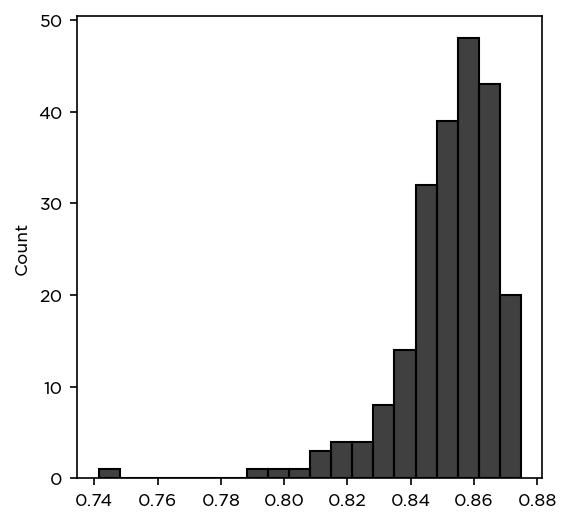

In [127]:
plt.figure(figsize=(4,4),dpi=150)
sns.histplot(input_output_similarity,bins=20,color='k');

<AxesSubplot:>

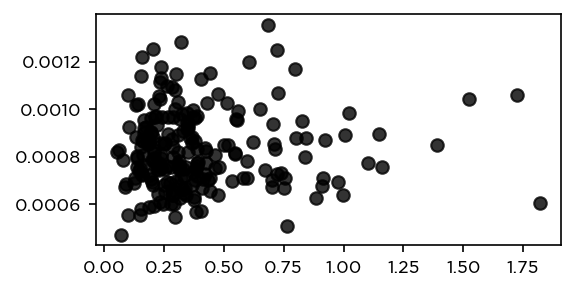

In [128]:
plt.figure(figsize=(4,2),dpi=150)
sns.regplot(connectivity.sum(axis=0),simple_human_dynamics.var(axis=1),color='k',fit_reg=False)

In [129]:
N_TRIALS = 10
all_trials = np.zeros((len(connectivity),len(connectivity),N_TRIALS))

In [130]:
for trial in range(N_TRIALS):
    temp = pd.read_pickle(f'results/causal_modes_l_w_{len(connectivity)}_{trial}.pickle').groupby(level=0).std().fillna(0)
    all_trials[:,:,trial] = temp

In [131]:
averaged_ci = all_trials.mean(axis=2)
averaged_ci = pd.DataFrame(averaged_ci)

In [132]:
ut.check_symmetric(averaged_ci)

False

In [133]:
lognorm_ci = ut.minmax_normalize(ut.log_normalize(averaged_ci))
np.fill_diagonal(lognorm_ci,0.)

lognorm_comm = ut.minmax_normalize(ut.log_normalize(communicability_wei(connectivity)))
np.fill_diagonal(lognorm_comm,0.)

lognorm_sc = ut.minmax_normalize(ut.log_normalize(connectivity))
np.fill_diagonal(lognorm_sc,0.)
lognorm_sc = np.where(lognorm_sc!=1,lognorm_sc,0)
difference = lognorm_ci-lognorm_comm

scaler = StandardScaler()
difference = scaler.fit_transform(difference)
np.fill_diagonal(difference,0.)

difference_outgoing = ut.make_influence_ratio(difference,axis=0)
difference_incoming = ut.make_influence_ratio(difference,axis=1)

difference_direct = pd.DataFrame(difference).where(connectivity!=0)
difference_indirect = pd.DataFrame(difference).where(connectivity==0)

direct_influence = pd.DataFrame(lognorm_ci).where(connectivity!=0)
indirect_influence = pd.DataFrame(lognorm_ci).where(connectivity==0)

<AxesSubplot:>

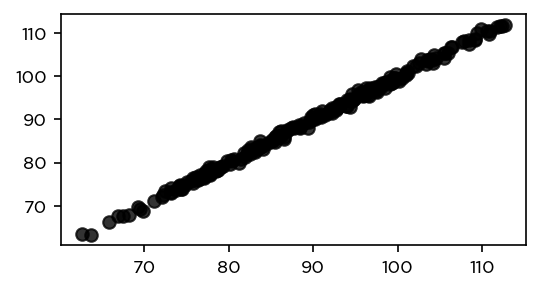

In [134]:
plt.figure(figsize=(4,2),dpi=150)
sns.regplot(lognorm_ci.sum(axis=0),lognorm_ci.sum(axis=1),fit_reg=False,color='k')

<AxesSubplot:ylabel='Count'>

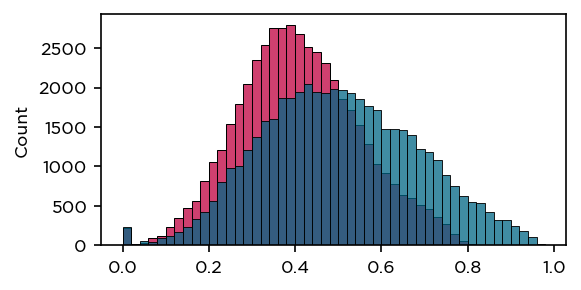

In [135]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(lognorm_ci.flatten(),binwidth=0.02,color=RED)
sns.histplot(lognorm_comm.flatten(),binwidth=0.02,color=DEEP_BLUE)


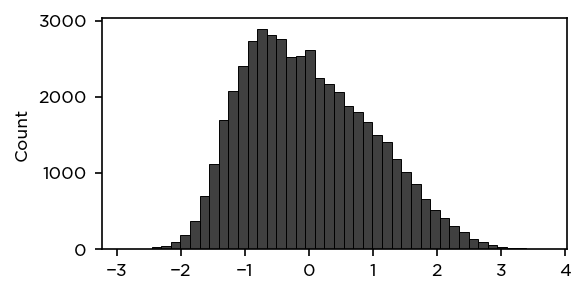

In [136]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(difference.flatten(),binwidth=0.15,color='k');

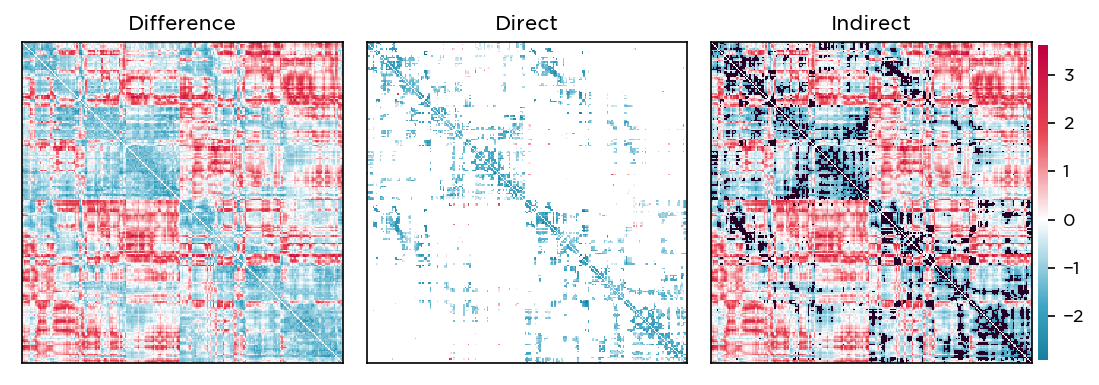

In [137]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(7,3.5),dpi=150)
cbar_ax = fig.add_axes([.99, .2, .01, .6])

sns.heatmap(difference,square=True,xticklabels=False,yticklabels=False,
            cmap=diverge_from_white,cbar=False,ax=axes['A'],linewidths=0,center=0, linecolor='k')

sns.heatmap(difference_direct,square=True,xticklabels=False,yticklabels=False,center=0, 
            cmap=diverge_from_white,cbar=False,ax=axes['B'],linewidths=0,linecolor='k')

sns.heatmap(difference_indirect,square=True,xticklabels=False,yticklabels=False, 
            cmap=diverge_from_white,cbar_ax=cbar_ax,ax=axes['C'],linewidths=0, center=0, linecolor='k')
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Difference')
axes['B'].title.set_text('Direct')
axes['C'].title.set_text('Indirect')
axes['C'].set_facecolor(PURPLEST)
fig.tight_layout(pad=1)

In [156]:
topological_distance = -np.log10(connectivity.copy(order='C')/np.max(connectivity))
shortest_path_distance,_ = distance_wei_floyd(np.abs(topological_distance))

<AxesSubplot:>

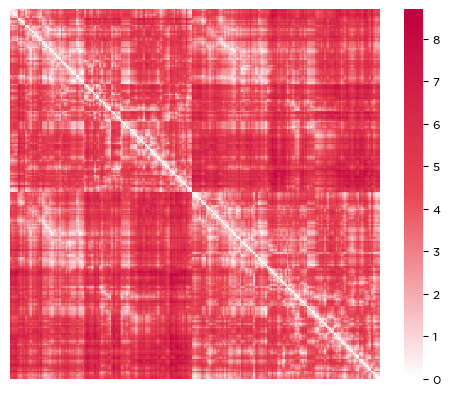

In [160]:
sns.heatmap(shortest_path_distance,square=True,xticklabels=False,yticklabels=False, 
            cmap=white_red_mono,cbar=True,linewidths=0,linecolor='k');

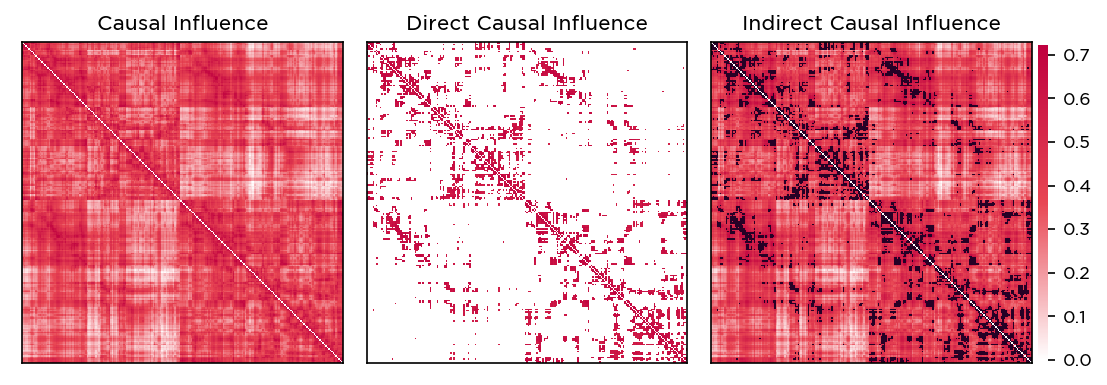

In [33]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(7,3.5),dpi=150)
cbar_ax = fig.add_axes([.99, .2, .01, .6])

sns.heatmap(lognorm_ci,square=True,xticklabels=False,yticklabels=False,
            cmap=white_red_mono,cbar=False,ax=axes['A'],linewidths=0, linecolor='k')

sns.heatmap(direct_influence,square=True,xticklabels=False,yticklabels=False,center=0, 
            cmap=white_red_mono,cbar=False,ax=axes['B'],linewidths=0,linecolor='k')

sns.heatmap(indirect_influence,square=True,xticklabels=False,yticklabels=False, 
            cmap=white_red_mono,cbar_ax=cbar_ax,ax=axes['C'],linewidths=0, linecolor='k')
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Causal Influence')
axes['B'].title.set_text('Direct Causal Influence')
axes['C'].title.set_text('Indirect Causal Influence')
axes['C'].set_facecolor(PURPLEST)
fig.tight_layout(pad=1)
#plt.savefig(f"causal_influences.pdf",dpi=600,bbox_inches='tight')

In [34]:
influence_gradient = pd.DataFrame(ut.minmax_normalize(ut.threshold(5,indirect_influence).sum(0).values),index=labels)

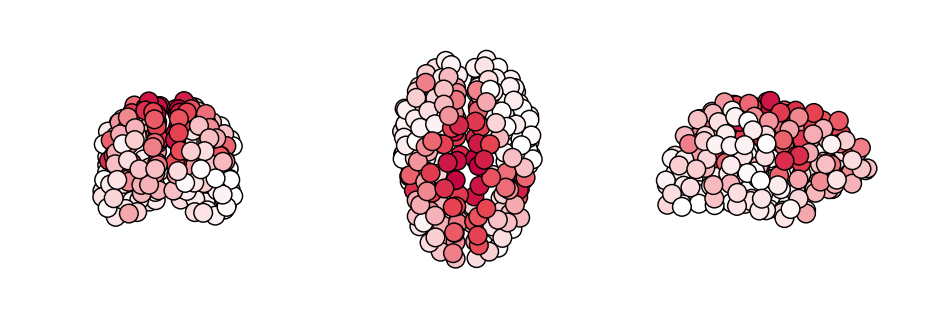

In [35]:
scatter_kw = dict(alpha=1,linewidths=0.7,edgecolors='k')
size=80
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(6,2),subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(influence_gradient,coordinates,axes['A'],view=sagittal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_gradient,coordinates,axes['B'],view=axial,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_gradient,coordinates,axes['C'],view=coronal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)

fig.tight_layout(pad=0.1)
plt.savefig(f"causal_gradient.pdf",dpi=600,bbox_inches='tight')

In [36]:
influence_gradient.sort_values(0,ascending=False).head(50)

,0
superiorfrontal,1.000000
posteriorcingulate,0.989598
superiorfrontal,0.957347
superiorfrontal,0.892925
caudalanteriorcingulate,0.854730
superiorfrontal,0.844309
superiorfrontal,0.832810
paracentral,0.817338
paracentral,0.810961
parsopercularis,0.787934


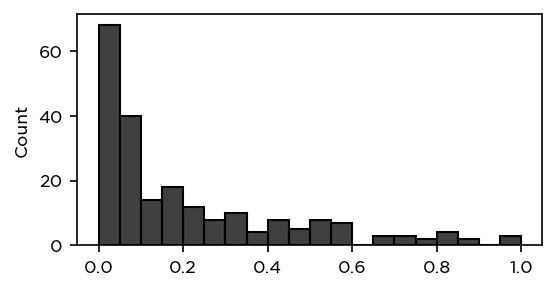

In [37]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(influence_gradient.values.flatten(),binwidth=0.05,color='k');

In [38]:
# warnings.filterwarnings("ignore")


# lesion_params = {'adjacency_matrix': connectivity, 'input': input_noise, 'model_kwargs': model_params}

# ci_mat = msa.estimate_causal_influences(elements=list(range(N_NODES)),
#                                         objective_function=ut.lesion_simple_nodes,
#                                         objective_function_params=lesion_params,
#                                         n_permutations=1_000, 
#                                         n_cores=-1,
#                                         parallelize_over_games=True,
#                                         permutation_seed=SEED)

# causal_influences = ci_mat.groupby(level=0).var().fillna(0)


In [39]:
# plt.figure(dpi=150)
# for i in range(n_neurons):
#     plt.plot(ci_mat[i][2],'k',alpha=0.3) # influence on the node
#     plt.plot(ci_mat[2][i],'r',alpha=0.3) # influenced by the node

<AxesSubplot:>

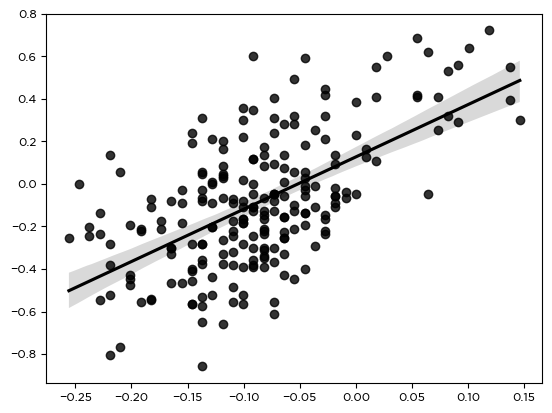

In [40]:
sns.regplot(difference_outgoing,difference_incoming,fit_reg=True,color='k')

In [41]:
influencers = ut.threshold(1,averaged_ci).sum(axis=0)
followers = ut.threshold(1,averaged_ci).sum(axis=1)
influence_ratio = influencers - followers

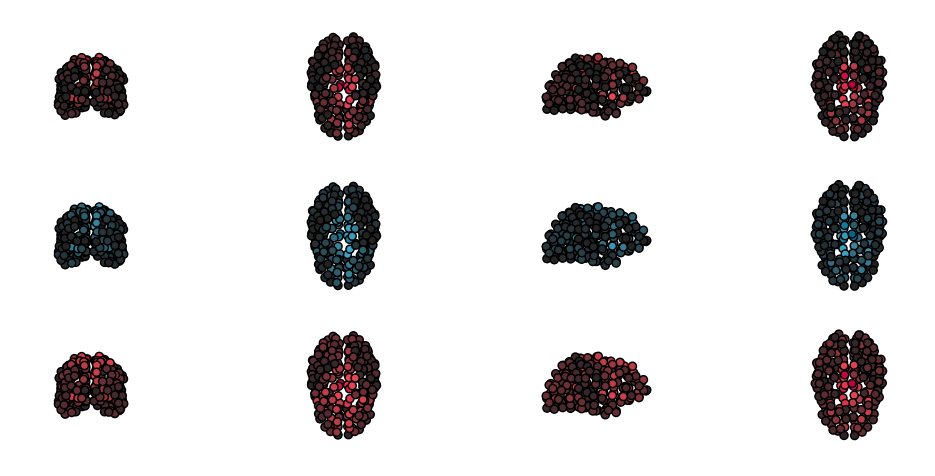

In [42]:
size=15
fig,axes = plt.subplot_mosaic([['A','B','C','D'],
                               ['E','F','G','H'],
                               ['L','M','N','O'],
                               ],figsize=(7.3,3),subplot_kw=dict(projection='3d'),dpi=150)
ut.brain_plotter(influencers,coordinates,axes['A'],view=sagittal,size=size,cmap=black_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influencers,coordinates,axes['B'],view=axial,size=size,cmap=black_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influencers,coordinates,axes['C'],view=coronal,size=size,cmap=black_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influencers,coordinates,axes['D'],view=bottom,size=size,cmap=black_red_mono,scatter_kwargs=scatter_kw)

ut.brain_plotter(followers,coordinates,axes['E'],view=sagittal,size=size,cmap=black_blue_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(followers,coordinates,axes['F'],view=axial,size=size,cmap=black_blue_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(followers,coordinates,axes['G'],view=coronal,size=size,cmap=black_blue_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(followers,coordinates,axes['H'],view=bottom,size=size,cmap=black_blue_mono,scatter_kwargs=scatter_kw)

ut.brain_plotter(connectivity.sum(axis=0),coordinates,axes['L'],view=sagittal,size=size,cmap=black_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(connectivity.sum(0),coordinates,axes['M'],view=axial,size=size,cmap=black_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(connectivity.sum(0),coordinates,axes['N'],view=coronal,size=size,cmap=black_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(connectivity.sum(0),coordinates,axes['O'],view=bottom,size=size,cmap=black_red_mono,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=0.1)

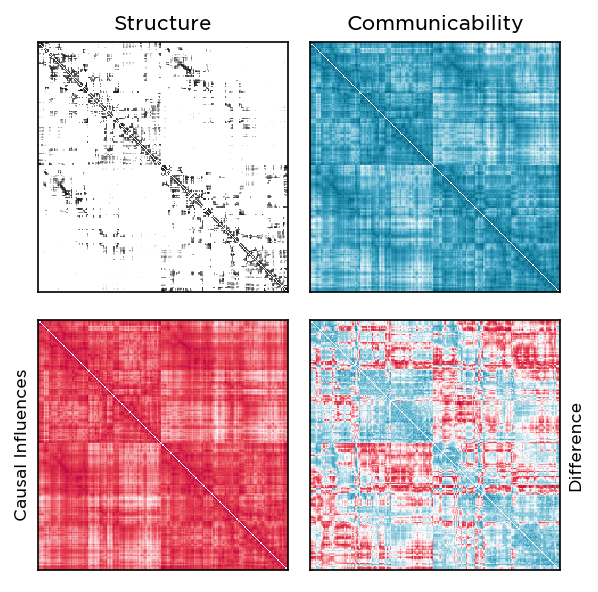

In [43]:
fig,axes = plt.subplot_mosaic([['A','CA'],
                               ['CI','DI']],figsize=(4,4),dpi=150)

sns.heatmap(lognorm_sc,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['A'],linewidths=0, linecolor='k')
sns.heatmap(lognorm_comm,square=True,xticklabels=False,yticklabels=False,
            cmap=white_blue_mono,cbar=False,ax=axes['CA'],linewidths=0, linecolor='k')

sns.heatmap(lognorm_ci,square=True,xticklabels=False,yticklabels=False,
            cmap=white_red_mono,cbar=False,ax=axes['CI'],linewidths=0, linecolor='k')
sns.heatmap(difference,square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=diverge_from_white,cbar=False,ax=axes['DI'],linewidths=0, linecolor='k')

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Structure')
axes['CA'].title.set_text('Communicability')
axes['CI'].set_ylabel("Causal Influences")
axes['DI'].set_ylabel("Difference")
axes['DI'].yaxis.set_label_position("right")
fig.tight_layout(pad=1)
#plt.savefig(f"human_propagation.pdf",dpi=600,bbox_inches='tight')

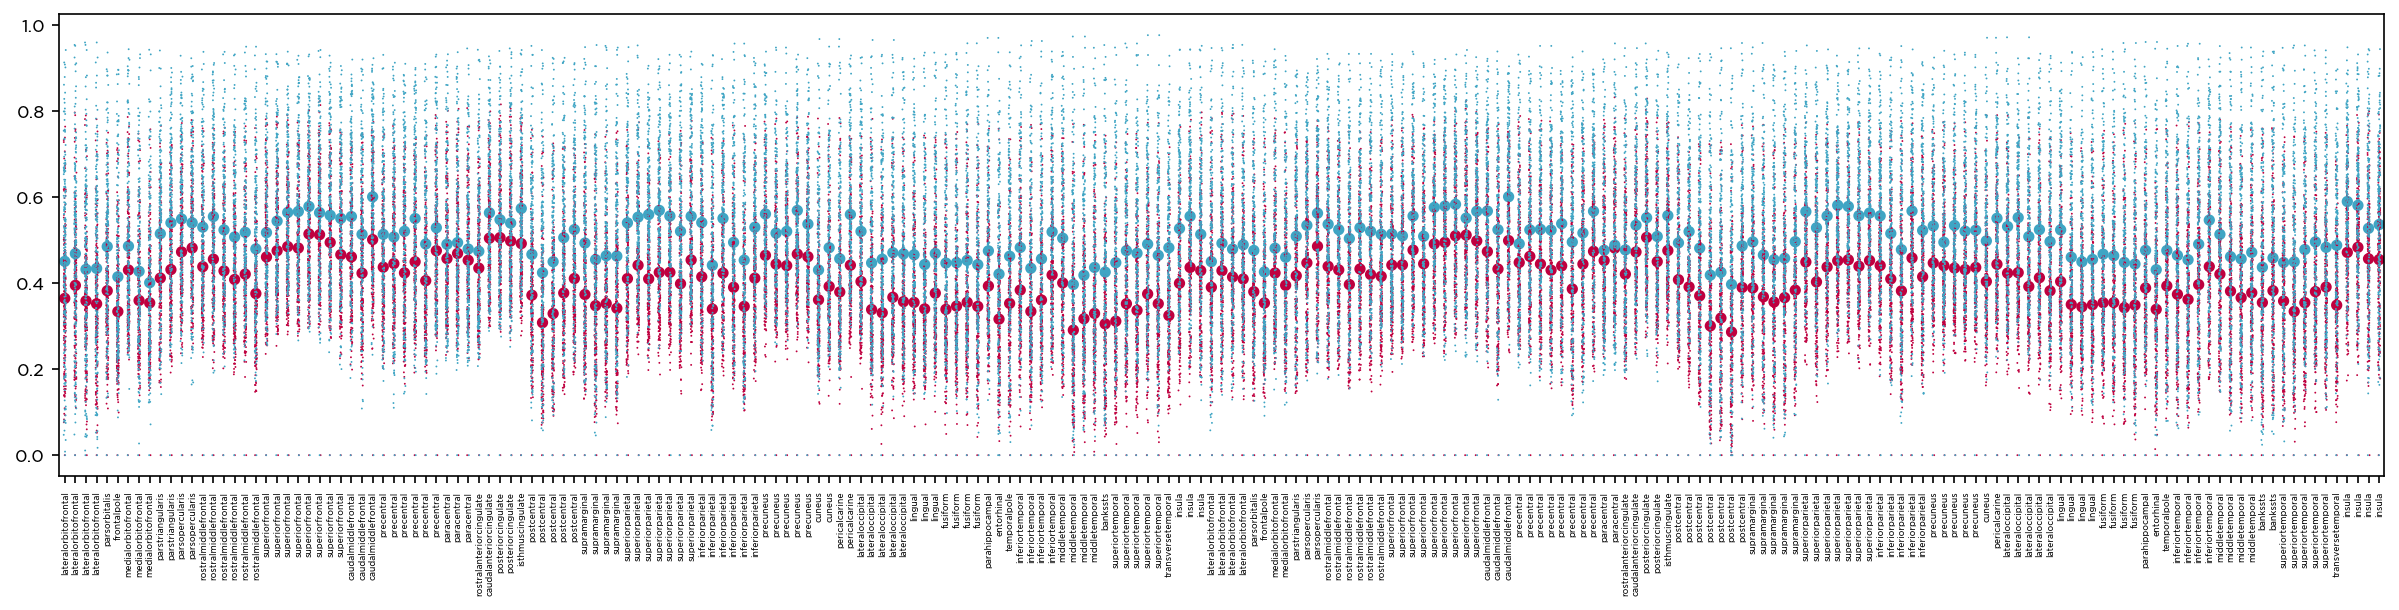

In [44]:
plt.figure(figsize=(20,4),dpi=150)
sns.pointplot(data=lognorm_ci,color=RED,label='Causal Influence',join=False,markers='.',errwidth=0.8)
sns.pointplot(data=lognorm_comm,color=BLUE,label='Communicability',join=False,markers='.',errwidth=0.8)

sns.stripplot(data=lognorm_ci,color=RED,label='Causal Influence',size=0.9)
sns.stripplot(data=lognorm_comm,color=BLUE,label='Communicability',size=0.9)
plt.xticks(ticks = [i for i,_ in enumerate(labels)],labels=labels,rotation=90,fontsize=4);

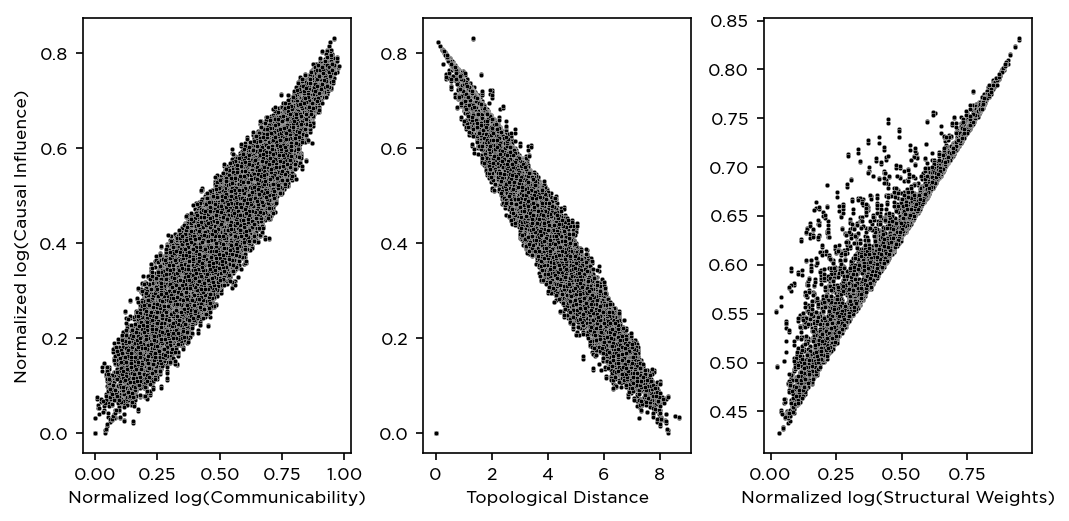

In [168]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(7,3.5),dpi=150)
sns.scatterplot(x=lognorm_comm.flatten(),y=lognorm_ci.flatten(),color='k',ax=axes['A'],s=5)
sns.scatterplot(shortest_path_distance.flatten(),lognorm_ci.flatten(),color='k',ax=axes['B'],s=5)

sns.scatterplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=lognorm_ci.flatten()[lognorm_sc.flatten()!=0],color='k',ax=axes['C'],s=5)
axes['A'].set_xlabel('Normalized log(Communicability)')
axes['A'].set_ylabel('Normalized log(Causal Influence)')
axes['B'].set_xlabel('Topological Distance')

axes['C'].set_xlabel('Normalized log(Structural Weights)')
fig.tight_layout(pad=1);
plt.savefig(f"correlations.pdf",dpi=600,bbox_inches='tight')